# Detecting individual trees from the LiDAR point cloud data
The primary task is to develop a pipeline for **detecting individual trees** from the LiDAR point
cloud data. The goal is to **identify the locations of tree tops** within the forest plots and compare
the detected trees with the ground truth field inventory data.

In [100]:
# necessary libraries
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import os
import math
import threading
import queue
import scipy
from scipy import ndimage
from scipy import stats

# 1. Preprocess the Data

## Load the LiDAR point cloud data and normalize it if needed.

In [3]:
data = os.getcwd()+"/data/"
with open(data+"field_survey.geojson") as f:
    field_survey = gpd.read_file(f)
field_survey.shape
field_survey.head()

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)


In [3]:
height_described = field_survey["height"].dropna().describe()
min_height = height_described["min"]
max_height = height_described["max"]

print(max_height)

34.2


In [106]:
def mean_point(arr):
    """arr = 2d numpy array, returns point with mean x and mean y"""
    rows, columns = arr.shape
    x_sum = 0
    y_sum = 0
    for x,y in arr:
        x_sum += x
        y_sum += y
    return(x_sum/rows,y_sum/rows)

def check_is_aligned(xyplane,pval):  
    """based on the assumption that a plot that is not turned properly will not have a uniform spread of points along the x and y axes"""
    rows, columns = xyplane.shape
    rng = np.random.default_rng()
    px = stats.ks_2samp([x for x,y in xyplane],stats.uniform.rvs(size=rows, random_state=rng)).pvalue
    py = stats.ks_2samp([y for x,y in xyplane],stats.uniform.rvs(size=rows, random_state=rng)).pvalue
    p = min(px,py)
    return(p > pval)

def find_corners(xyplane):
    """xyplane = 2d numpy array
    supposes that this is a cloud in the shape of a diamond or rectangle, that is not aligned with the axes, and that has been
    normalised to [0,1]x[0,1]
    finds three of the corner points of this cloud, and angle in rad between the line between the first two corners, and the x-axis"""
    xcm , ycm = mean_point(xyplane)         #get mean point of the cloud
    r = (min([1-xcm,xcm,ycm,1-ycm]))        #r = distance between mean point and closest edge (our cloud is defined in [0,1]x[0,1])
    
    KDT = scipy.spatial.KDTree(xyplane)     #compute KDTree for later
    ind_to_rem = KDT.query_ball_point([xcm,ycm],r,workers = -1)
    corner_xyplane = np.delete(xyplane,ind_to_rem, axis=0)  #remove all points within radius r of the mean point
                #this allows us to keep the corners (by construction and assumptions), but also remove many points allowing
                #for faster and more accurate computation
    x1 = 1      #(x1,y1) = point with lowest y
    y1 = 1
    x2 = 0      #(x2,y2) = point with highest x
    y2 = 0
    x3 = 1      #(x3,y3) = point with lowest x
    y3 = 0
    i = 0
    for x,y in corner_xyplane:
        if x > x2:
            x2,y2 = x,y
        if y < y1:
            x1,y1 = x,y
        if x < x3:
            x3,y3 = x,y
    d = math.sqrt((x2-x1)**2+(y2-y1)**2)
    alpha = math.acos((x2-x1)/d)
    return(x1,x2,y1,y2,x3,y3,alpha)

def rotate_point_2D(xc,yc,xp,yp,z,alpha):
    """xc,yc = coordinates of point to be rotated around
    xp,yp = coordinates of point to rotate
    alpha = angle in rad to rotate counter clockwise
    z = passthrough variable for ease of usage"""
    x = xc + math.cos(alpha) * (xp - xc) - math.sin(alpha) * (yp - yc)
    y = yc + math.sin(alpha) * (xp - xc) + math.cos(alpha) * (yp - yc)
    return [x,y,z]

def rotate_cloud(df,pval=0.05):
    """df = dataframe with columns x y and z (no column plot!)
        pval = p value to be used for kolmogorov smirnov test"""
    xyplane = df.drop(columns = ["z"]).to_numpy()
    if check_is_aligned(xyplane,pval):                                      #if the cloud is already a nice rectangle then there is no need
        return(df)                                                          #for transformations
    else:

        #STEP 1: ROTATION TO ALIGN ONE SIDE OF CLOUD WITH AXIS

        x1,x2,y1,y2,x3,y3,alpha = find_corners(xyplane)                     #find 3 of the 4 corners needed for rotation and translation
        vals = df.to_numpy()                                                #store values in an array for easy iteration
        vals_rotated = [rotate_point_2D(x1,y1,x,y,z,-alpha) for x,y,z in vals]      #apply rotation around corner (x1,y1) by -alpha rad
                                                                            #note that the rotation is carried out in the xy plane and the 
                                                                            #z coordinates are left unchanged
        df_rotated = pd.DataFrame(vals_rotated).rename(columns={0: "x", 1: "y", 2: "z"})    #create new dataframe with the rotated points
        df_rotated = (df_rotated-df_rotated.min())/(df_rotated.max()-df_rotated.min())      #renormalize dataframe
        vals_rotated = df_rotated.to_numpy()                                #store values in an array for easy iteration

        #--------------

        #STEP 2: TRANSLATION TO ALIGN OTHER SIDE OF CLOUD WITH AXIS

        i1 = df.index[(df['x'] == x1) & (df['y'] == y1)].tolist()[0]        #get indexes of corners before transformations
        i3 = df.index[(df['x'] == x3) & (df['y'] == y3)].tolist()[0]        #to easily get their values after the transformations
        x1,y1,z1 = df_rotated.iloc[i1].to_numpy()                           #retrieve new corners
        x3,y3,z3 = df_rotated.iloc[i3].to_numpy()

        m = (y3-y1)/(x3-x1)                                                 #get equation of line between (x1,y1) and (x3,y3)
        p = y1 - m                                                          #where y = mx + p
        vals_shifted = [(x-(y-p)/m,y,z)for x,y,z in vals_rotated]           #shift values to get a rectangle
        df_shifted = pd.DataFrame(vals_shifted).rename(columns={0: "x", 1: "y", 2: "z"})    #create new dataframe with translated points
        df_shifted = (df_shifted-df_shifted.min())/(df_shifted.max()-df_shifted.min())      #renormalize dataframe
        return(df_shifted)

def load_lidar():
    """reads the .las files in succession, for each one normalises them into a square base, within 
    [0,1]x[0,1]x[0,1], puts all the (x,y,z) values into a dataframe, each with a number in the column plot
    corresponding to the file they were obtained from. The normalisation is done on a plot per plot basis."""
    for i in range(1,11):
        temp = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz     #reads file as numpy array
        tempdf = pd.DataFrame(temp)                                     #converts numpy array to dataframe
        tempdf = tempdf.rename(columns={0: "x", 1: "y", 2: "z"})        #rename columns
        tempdf = (tempdf-tempdf.min())/(tempdf.max()-tempdf.min())      #linear normalisation to [0,1] of all coordinates
        tempdf = rotate_cloud(tempdf)                                   #apply rotation and translation to obtain a nice square
        tempdf["plot"] = i                                              #add column to store which file these points come from
        if i == 1:
            lidardf = tempdf.copy()
        else:
            lidardf = pd.concat([lidardf,tempdf],ignore_index= True).copy()
    return(lidardf)

lidardf = load_lidar()


Take a look at our point clouds

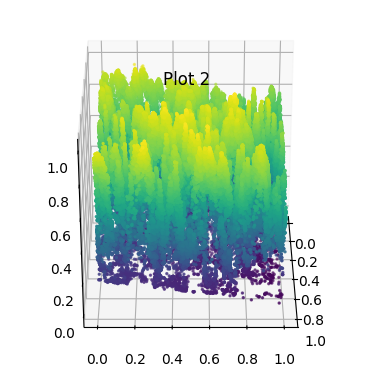

In [107]:
def plot_3d_cloud(df,i):
    #plot1 = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
    plot = df.loc[df["plot"] == i]
    plot = plot.drop(columns=['plot']).to_numpy()
    plot -= plot.min(axis=0, keepdims=True)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.scatter(
        *plot.swapaxes(0, 1),
        c=plot[:, 2],
        s=2,
    )

    ax.view_init(elev=30, azim=0)

    ax.set_title("Plot " + str (i), y=0.83)

    ax.set_aspect("equal")

plot_3d_cloud(lidardf,2)

## Filter irrelevant points (e.g., ground points below a height threshold) and remove residual noise.

In [20]:
def num_neigh(df,r):
    """df = dataframe cotaining the columns x y z and plot, for only one plot
    returns array containing the number of neighbours within radius r of all points"""
    KDT = scipy.spatial.KDTree(np.asarray(df.drop(columns=['plot'])))        #compute KDTree for fast computation
    arr = df.drop(columns=['plot']).to_numpy()                               #create array of (x,y,z) for iteration
    return([KDT.query_ball_point(point,r,workers = -1,return_length = True) for point in arr])

def dist_filter(df,r,a):
    """df = dataframe containing the columns x y z and plot, for all plots
    returns dataframe, where the points where the number of neighbours within radius r lie in the lower a quantile of the 
    number of neighbours are excluded"""
    iter = 0                                        #for iterative creation of dataframe
    for i in df["plot"].unique():                   #iterate through plots
        df_i = df.loc[df["plot"] == i]              #extract selected plot
        df_i["num_neigh"] = num_neigh(df_i,r)       #add column containing for each row the corresponding number of neighbours within r
        min_neigh = df_i.quantile(a)["num_neigh"]   #get quantile for number of neighbours
        df_i = df_i.loc[df_i["num_neigh"] >= min_neigh].drop(columns =["num_neigh"])
                                                    #drop every row with too few neighbours
        if iter == 0:                               #build dataframe iteratively
            res = df_i
            iter += 1
        else:
            res = pd.concat([res,df_i],ignore_index= True)
    return(res)

def load_and_filter(a1,a2,r1,r2):
    """ a1 = specifies which quantile to use to filter out lower points
        a2 = specifies which quantile to use to filter out points with few neighbours
        r1 = radius to check for neighbours for first filtering
        r2 = radius to check for neighbours for second filtering
        
        Returns dataframe where lower a1 quantile of points are filtered out (plot per plot), and
        applies two succesive radius based filters (plot per plot)"""

    df = load_lidar()

    #Filter out lower a quantile, where the quantiles are computed plot per plot
    #Otherwise, if the ground level is not the same for each plot we remove
    #inequally between the different plots

    for i in df["plot"].unique():
        zQ = df.loc[df["plot"] == i].quantile(a1)["z"]               #compute height quantile of plot
        df = df.loc[-((df["z"] < zQ) & (df["plot"] == i))]      #remove low points from selected plot

    #--------------

    #Distance based filtering using KDTrees

    df = dist_filter(dist_filter(df,r1,a2),r2,a2)               #apply two filters successively, one rougher one finer

    #--------------

    return(df)

lidardf = load_and_filter(a1 = 0.2, a2 = 0.1,r1 = 0.1,r2 =0.01)

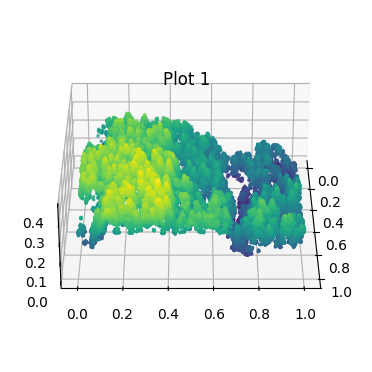

In [22]:
plot_3d_cloud(lidardf,1)

## Partition the dataset into training and testing sets.